Experiment E1-8:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 30
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=1e-5
- augmentation

model:
- self.base_model(x)
- unfreeze 3 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (5120,512)->Dropout(0.5)->Relu->(512,1)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-8"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 30
config.LEARNING_RATE = 1e-5

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-3:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2 * 2, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/30
  Train Loss: 0.6005 | Train Acc: 0.6774
  Val Loss  : 0.4908 | Val Acc: 0.7940
  Train Precision: 0.6609 | Recall: 0.8404 | F1: 0.7399 | ROC AUC: 0.7515
  Train Confusion Matrix: TN=765, FP=824, FN=305, TP=1606
  Val Precision: 0.7662 | Recall: 0.8962 | F1: 0.8261 | ROC AUC: 0.8800
  Val Confusion Matrix: TN=457, FP=224, FN=85, TP=734
2
Epoch 2/30
  Train Loss: 0.4569 | Train Acc: 0.7897
  Val Loss  : 0.3881 | Val Acc: 0.8387
  Train Precision: 0.7765 | Recall: 0.8634 | F1: 0.8176 | ROC AUC: 0.8746
  Train Confusion Matrix: TN=1114, FP=475, FN=261, TP=1650
  Val Precision: 0.8703 | Recall: 0.8278 | F1: 0.8486 | ROC AUC: 0.9196
  Val Confusion Matrix: TN=580, FP=101, FN=141, TP=678
3
Epoch 3/30
  Train Loss: 0.3789 | Train Acc: 0.8251
  Val Loss  : 0.3368 | Val Acc: 0.8527
  Train Precision: 0.8265 | Recall: 0.8603 | F1: 0.8431 | ROC AUC: 0.9127
  Train Confusion Matrix: TN=1244, FP=345, FN=267, TP=1644
  Val Precision: 0.8785 | Recall: 0.8474 | F1: 0.8626 | ROC AUC: 0.936

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.600469,0.677429,0.660905,0.840398,0.739922,0.751463,"{'tn': 765, 'fp': 824, 'fn': 305, 'tp': 1606}",0.490762,0.794000,0.766180,...,0.880021,"{'tn': 457, 'fp': 224, 'fn': 85, 'tp': 734}",765,824,305,1606,457,224,85,734
1,0.456855,0.789714,0.776471,0.863422,0.817641,0.874615,"{'tn': 1114, 'fp': 475, 'fn': 261, 'tp': 1650}",0.388138,0.838667,0.870347,...,0.919584,"{'tn': 580, 'fp': 101, 'fn': 141, 'tp': 678}",1114,475,261,1650,580,101,141,678
2,0.378912,0.825143,0.826546,0.860283,0.843077,0.912659,"{'tn': 1244, 'fp': 345, 'fn': 267, 'tp': 1644}",0.336792,0.852667,0.878481,...,0.936126,"{'tn': 585, 'fp': 96, 'fn': 125, 'tp': 694}",1244,345,267,1644,585,96,125,694
3,0.348706,0.846000,0.846465,0.877028,0.861475,0.925221,"{'tn': 1285, 'fp': 304, 'fn': 235, 'tp': 1676}",0.308834,0.866667,0.877900,...,0.943857,"{'tn': 581, 'fp': 100, 'fn': 100, 'tp': 719}",1285,304,235,1676,581,100,100,719
4,0.325758,0.856000,0.858380,0.881737,0.869902,0.934330,"{'tn': 1311, 'fp': 278, 'fn': 226, 'tp': 1685}",0.298977,0.871333,0.895202,...,0.947596,"{'tn': 598, 'fp': 83, 'fn': 110, 'tp': 709}",1311,278,226,1685,598,83,110,709
5,0.314332,0.852571,0.853523,0.881214,0.867147,0.938458,"{'tn': 1300, 'fp': 289, 'fn': 227, 'tp': 1684}",0.288268,0.875333,0.892060,...,0.949830,"{'tn': 594, 'fp': 87, 'fn': 100, 'tp': 719}",1300,289,227,1684,594,87,100,719
6,0.279903,0.878571,0.885774,0.892726,0.889236,0.952320,"{'tn': 1369, 'fp': 220, 'fn': 205, 'tp': 1706}",0.296013,0.874667,0.917881,...,0.950590,"{'tn': 619, 'fp': 62, 'fn': 126, 'tp': 693}",1369,220,205,1706,619,62,126,693
7,0.279856,0.888000,0.891697,0.904762,0.898182,0.951681,"{'tn': 1379, 'fp': 210, 'fn': 182, 'tp': 1729}",0.285865,0.877333,0.915033,...,0.952304,"{'tn': 616, 'fp': 65, 'fn': 119, 'tp': 700}",1379,210,182,1729,616,65,119,700
8,0.273238,0.883143,0.888314,0.899006,0.893628,0.954574,"{'tn': 1373, 'fp': 216, 'fn': 193, 'tp': 1718}",0.272715,0.882667,0.899379,...,0.954140,"{'tn': 600, 'fp': 81, 'fn': 95, 'tp': 724}",1373,216,193,1718,600,81,95,724
9,0.269286,0.891143,0.893519,0.908948,0.901167,0.955304,"{'tn': 1382, 'fp': 207, 'fn': 174, 'tp': 1737}",0.272097,0.880000,0.912258,...,0.955626,"{'tn': 613, 'fp': 68, 'fn': 112, 'tp': 707}",1382,207,174,1737,613,68,112,707


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.490762  0.794000       0.766180    0.896215  0.826111    0.880021
1   0.388138  0.838667       0.870347    0.827839  0.848561    0.919584
2   0.336792  0.852667       0.878481    0.847375  0.862648    0.936126
3   0.308834  0.866667       0.877900    0.877900  0.877900    0.943857
4   0.298977  0.871333       0.895202    0.865690  0.880199    0.947596
5   0.288268  0.875333       0.892060    0.877900  0.884923    0.949830
6   0.296013  0.874667       0.917881    0.846154  0.880559    0.950590
7   0.285865  0.877333       0.915033    0.854701  0.883838    0.952304
8   0.272715  0.882667       0.899379    0.884005  0.891626    0.954140
9   0.272097  0.880000       0.912258    0.863248  0.887077    0.955626
10  0.270434  0.881333       0.925631    0.851038  0.886768    0.958133
11  0.255192  0.888667       0.913706    0.879121  0.896080    0.960192
12  0.265626  0.888000       0.864502    0.942613  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.255230,0.889124,0.890887,0.911408,0.900656,0.953998,0.271629,0.885244,0.903361,0.885958,0.894072,0.956092,1370.233333,218.766667,169.300000,1741.700000,602.266667,78.733333,93.400000,725.600000
std,0.093936,0.052336,0.056116,0.027101,0.042268,0.045107,0.054150,0.023728,0.031283,0.026613,0.020387,0.018096,136.961027,136.961027,51.790793,51.790793,31.729387,31.729387,21.796235,21.796235
min,0.168332,0.677429,0.660905,0.840398,0.739922,0.751463,0.226541,0.794000,0.766180,0.827839,0.826111,0.880021,765.000000,120.000000,107.000000,1606.000000,457.000000,51.000000,47.000000,678.000000
25%,0.191468,0.884357,0.889160,0.900445,0.894767,0.952883,0.239687,0.878000,0.897301,0.863858,0.885384,0.952763,1374.500000,150.750000,127.000000,1720.750000,596.500000,62.250000,82.000000,707.500000
50%,0.225385,0.904143,0.908689,0.917059,0.912571,0.968889,0.253218,0.891000,0.913396,0.890720,0.900256,0.962105,1413.000000,176.000000,158.500000,1752.500000,612.500000,68.500000,89.500000,729.500000
75%,0.278202,0.922571,0.922383,0.933543,0.929412,0.977549,0.282578,0.900667,0.920553,0.899878,0.908052,0.966382,1438.250000,214.500000,190.250000,1784.000000,618.750000,84.500000,111.500000,737.000000
max,0.600469,0.934286,0.937533,0.944008,0.939979,0.982681,0.490762,0.910000,0.932718,0.942613,0.917127,0.969532,1469.000000,824.000000,305.000000,1804.000000,630.000000,224.000000,141.000000,772.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   30.000000  30.000000        30.000000     30.000000  30.000000   
mean     0.255230   0.889124         0.890887      0.911408   0.900656   
std      0.093936   0.052336         0.056116      0.027101   0.042268   
min      0.168332   0.677429         0.660905      0.840398   0.739922   
25%      0.191468   0.884357         0.889160      0.900445   0.894767   
50%      0.225385   0.904143         0.908689      0.917059   0.912571   
75%      0.278202   0.922571         0.922383      0.933543   0.929412   
max      0.600469   0.934286         0.937533      0.944008   0.939979   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     30.000000  30.000000  30.000000      30.000000   30.000000   
mean       0.953998   0.271629   0.885244       0.903361    0.885958   
std        0.045107   0.054150   0.023728       0.031283    0.026613   
min        0.751463   0.226541   0.794000    

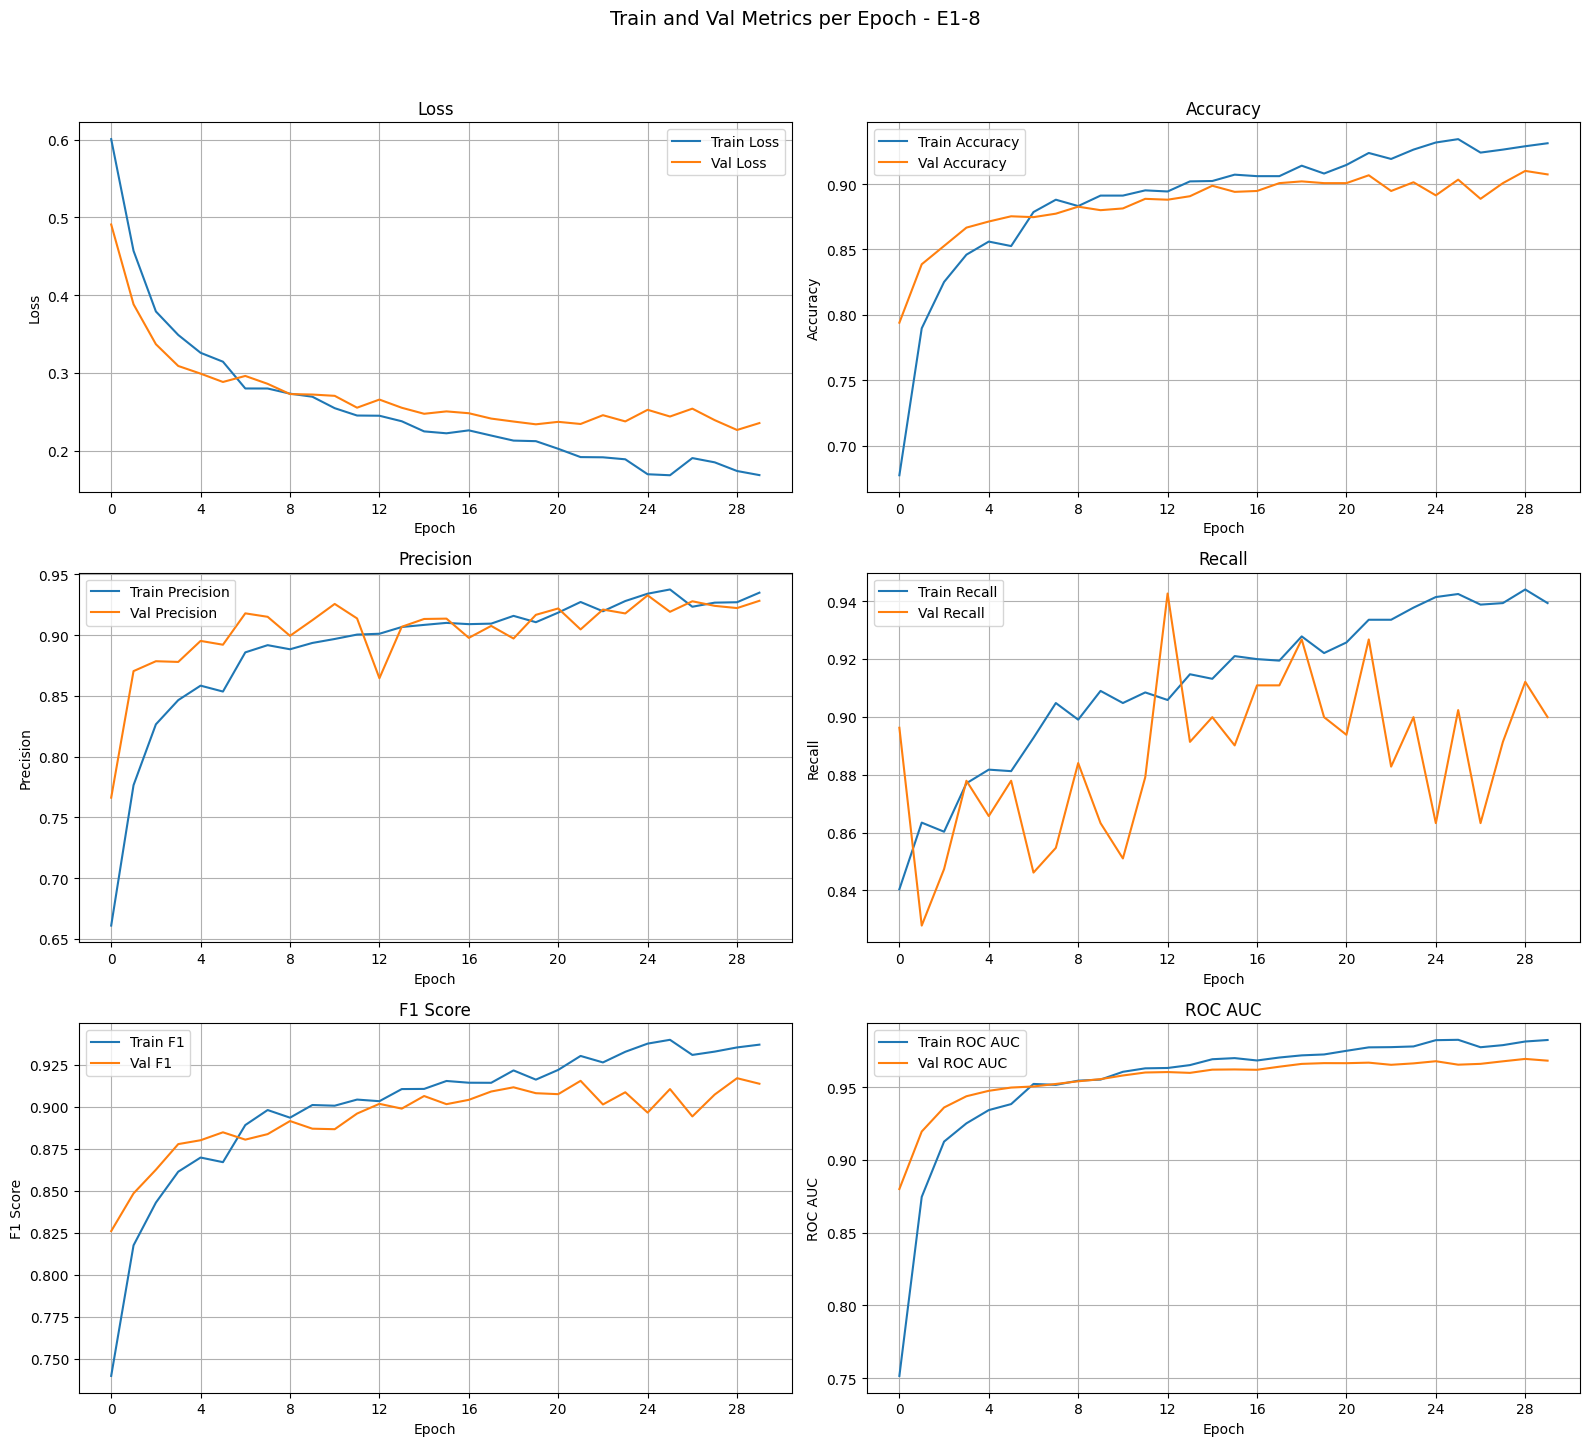

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,30.000000,30.000000,30.000000,30.000000
mean,1370.233333,218.766667,169.300000,1741.700000
std,136.961027,136.961027,51.790793,51.790793
min,765.000000,120.000000,107.000000,1606.000000
25%,1374.500000,150.750000,127.000000,1720.750000
50%,1413.000000,176.000000,158.500000,1752.500000
75%,1438.250000,214.500000,190.250000,1784.000000
max,1469.000000,824.000000,305.000000,1804.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000
mean,602.266667,78.733333,93.400000,725.600000
std,31.729387,31.729387,21.796235,21.796235
min,457.000000,51.000000,47.000000,678.000000
25%,596.500000,62.250000,82.000000,707.500000
50%,612.500000,68.500000,89.500000,729.500000
75%,618.750000,84.500000,111.500000,737.000000
max,630.000000,224.000000,141.000000,772.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)